# Reinforcement Learning Trading Bot
An attempt at a reinforcement learning training bot. This is a work in progress, will update with more information and more complex models to try and improve it. (follow along from Nicholas Renotte ([link](https://www.youtube.com/channel/UCHXa4OpASJEwrHrLeIzw7Yg) to channel).

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# gym libraries
import gym
import gym_anytrading

# stable Baselines 
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

C:\Users\midgl\anaconda3\envs\rltrader\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\midgl\anaconda3\envs\rltrader\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


## Load in Data
Data is for Amazon stock over the past year and is from market watch ([link](https://www.marketwatch.com/investing/stock/amzn/download-data?startDate=11/18/2020&endDate=11/17/2021)).

In [2]:
df = pd.read_csv("data/amazondata.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume
0,11/17/2021,"3,564.72","3,587.25","3,545.35","3,549.00","2,544,060"
1,11/16/2021,"3,539.00","3,576.50","3,525.15","3,540.70","2,217,071"
2,11/15/2021,"3,537.00","3,593.88","3,525.81","3,545.68","2,929,719"
3,11/12/2021,"3,485.00","3,540.73","3,447.05","3,525.15","2,689,434"
4,11/11/2021,"3,513.00","3,543.24","3,467.47","3,472.50","2,264,406"


In [4]:
df.dtypes

Date      object
Open      object
High      object
Low       object
Close     object
Volume    object
dtype: object

Couple things need to be addressed before continuing:
- For stable baselines to work the `Date` column needs to be in datetime format
- All other columns are objects, this is because each number contains a comma so this needs to be removed before converting to float for the RL model

In [5]:
df = df.replace(',','', regex=True)

In [6]:
cols = list(df.columns)
cols.remove('Date')
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object

Now all columns are in the correct format. Additionally stable baselines requires the `Date` column to be set as the index so lets do that.

In [8]:
df.set_index('Date', inplace=True)

In [9]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-11-17,3564.72,3587.25,3545.35,3549.00,2544060.0
2021-11-16,3539.00,3576.50,3525.15,3540.70,2217071.0
2021-11-15,3537.00,3593.88,3525.81,3545.68,2929719.0
2021-11-12,3485.00,3540.73,3447.05,3525.15,2689434.0
2021-11-11,3513.00,3543.24,3467.47,3472.50,2264406.0


Now the data is ready to be used in the RL model

## Loading the data into the gym environment

In [10]:
env = gym.make('stocks-v0', df=df, frame_bound=(150,250), window_size=5)

Now lets see how a trading bot would perform if it randomly put in Buy or Sell orders

info {'total_reward': -209.7799999999993, 'total_profit': 0.6493353609356164, 'position': 1}


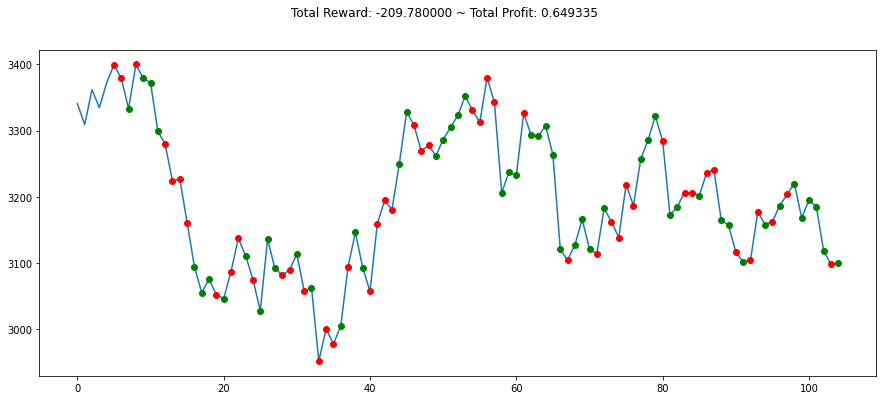

In [11]:
state = env.reset()
while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

Unsuprisingly a random trading bot is not effective and would have lost us 35% of our investment over 100 days

## Creating and training RL model
Now lets see if we can create a model that performs better than the random bot

In [12]:
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(150,230), window_size=5)
env = DummyVecEnv([env_maker])

In [13]:
model = A2C('MlpLstmPolicy', env, verbose=1)
model.learn(total_timesteps=50000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0.000785 |
| fps                | 28       |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 1.91e+03 |
---------------------------------
---------------------------------
| explained_variance | -115     |
| fps                | 785      |
| nupdates           | 100      |
| policy_entropy     | 0.693    |
| total_timesteps    | 500      |
| value_loss         | 5.48e-05 |
---------------------------------
---------------------------------
| explained_variance | 5.86e-05 |
| fps                | 851     

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 983      |
| nupdates           | 1600     |
| policy_entropy     | 0.47     |
| total_timesteps    | 8000     |
| value_loss         | 1.38e+04 |
---------------------------------
---------------------------------
| explained_variance | -8.02    |
| fps                | 989      |
| nupdates           | 1700     |
| policy_entropy     | 0.243    |
| total_timesteps    | 8500     |
| value_loss         | 0.000165 |
---------------------------------
---------------------------------
| explained_variance | -0.257   |
| fps                | 995      |
| nupdates           | 1800     |
| policy_entropy     | 0.0802   |
| total_timesteps    | 9000     |
| value_loss         | 2.61e-05 |
---------------------------------
---------------------------------
| explained_variance | -1.14    |
| fps                | 995      |
| nupdates           | 1900     |
| policy_entropy     | 0.0387   |
| total_timest

---------------------------------
| explained_variance | -0.223   |
| fps                | 1000     |
| nupdates           | 4700     |
| policy_entropy     | 0.0012   |
| total_timesteps    | 23500    |
| value_loss         | 1.1e-09  |
---------------------------------
----------------------------------
| explained_variance | -6.82e+03 |
| fps                | 1002      |
| nupdates           | 4800      |
| policy_entropy     | 0.00123   |
| total_timesteps    | 24000     |
| value_loss         | 1.16e-07  |
----------------------------------
---------------------------------
| explained_variance | 0.748    |
| fps                | 1003     |
| nupdates           | 4900     |
| policy_entropy     | 0.00139  |
| total_timesteps    | 24500    |
| value_loss         | 3.57e-10 |
---------------------------------
---------------------------------
| explained_variance | -0.199   |
| fps                | 1003     |
| nupdates           | 5000     |
| policy_entropy     | 0.00128  |
| tota

---------------------------------
| explained_variance | -0.127   |
| fps                | 1014     |
| nupdates           | 7700     |
| policy_entropy     | 0.000647 |
| total_timesteps    | 38500    |
| value_loss         | 1.42e-09 |
---------------------------------
---------------------------------
| explained_variance | -0.145   |
| fps                | 1015     |
| nupdates           | 7800     |
| policy_entropy     | 0.000656 |
| total_timesteps    | 39000    |
| value_loss         | 4.44e-10 |
---------------------------------
---------------------------------
| explained_variance | nan      |
| fps                | 1015     |
| nupdates           | 7900     |
| policy_entropy     | 0.000665 |
| total_timesteps    | 39500    |
| value_loss         | 6.6e-06  |
---------------------------------
---------------------------------
| explained_variance | -0.211   |
| fps                | 1016     |
| nupdates           | 8000     |
| policy_entropy     | 0.000674 |
| total_timest

With the model trained lets now test it over 20 days

In [14]:
env = gym.make('stocks-v0', df=df, frame_bound=(230,250), window_size=5)
obs = env.reset()
while True:
    obs = obs[np.newaxis,...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': -68.03999999999996, 'total_profit': 0.921400641681405, 'position': 1}


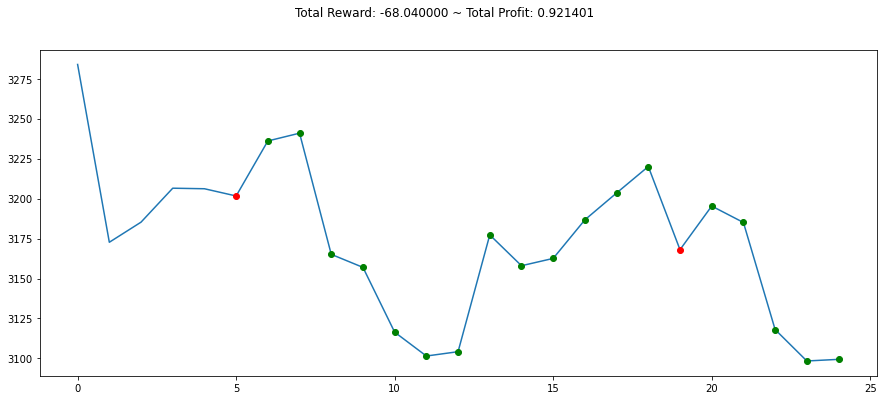

In [15]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

Unfortunately the bot has given us a 8% loss over 20 days. Of note that bot mainly buys and does not sell, unsure as to why this is. Next step is to add custom indicators into the model to try and improve its performance.